<a href="https://colab.research.google.com/github/arai37ASU/CSE572_HW3/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HW3 Task 1 : K-Means Clustering


Q1–Q3 RESULTS 
Metric      SSE               Iter   Time(s)   ARI
-----------------------------------------------------------
euclidean   15750350.821     40     59.02    0.413
cosine      2491.707         34     60.68    0.409
jaccard     6818.150         1      5.97     0.084


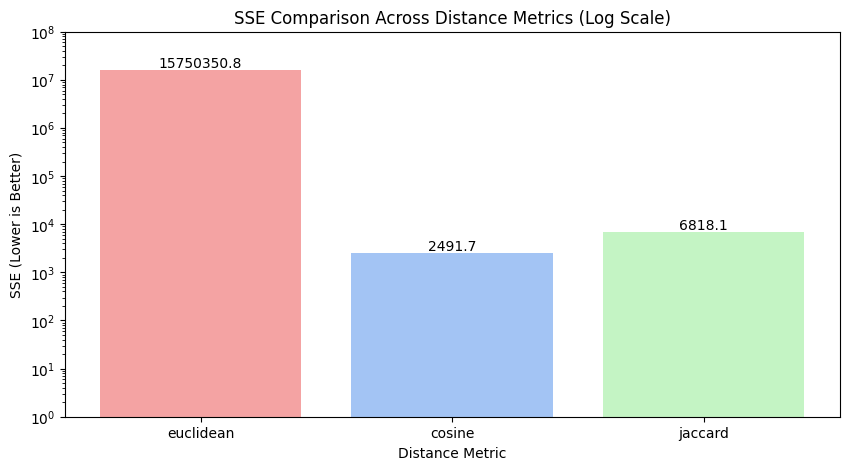


Q4 RESULTS 
      Metric  SSE (stop when centroid unchanged)  \
0  euclidean                        1.575035e+07   
1     cosine                        2.491707e+03   
2    jaccard                        6.818150e+03   

   SSE (stop when SSE increases)  SSE (stop when max-iterations reached)  
0                   1.575035e+07                            1.575045e+07  
1                   2.491707e+03                            2.491277e+03  
2                   6.818150e+03                            7.736870e+03  


In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

# Load Dataset
data = pd.read_excel("HW3 Dataset/data.xlsx")
labels = pd.read_excel("HW3 Dataset/label.xlsx").iloc[:, 0]

X = data.values.astype(float)
true_labels = labels.values
k = len(np.unique(true_labels))    # number of clusters


# Distance Functions
def euclidean_dist(a, b):
    return np.sqrt(np.sum((a - b)**2))

def cosine_dist(a, b):
    num = np.dot(a, b)
    den = np.linalg.norm(a) * np.linalg.norm(b)
    if den == 0:
        return 1
    return 1 - (num / den)

def jaccard_dist(a, b):
    a_bin = a > 0
    b_bin = b > 0
    inter = np.sum(a_bin & b_bin)
    union = np.sum(a_bin | b_bin)
    if union == 0:
        return 1
    return 1 - (inter / union)


# Compute SSE
def compute_sse(X, clusters, centroids, dist_fn):
    total = 0
    for c_idx, pts in clusters.items():
        for p in pts:
            total += dist_fn(X[p], centroids[c_idx])
    return total


# K-means (with stopping rules inside)
def kmeans_from_scratch(X, k, dist_fn, max_iter=500):
    n = X.shape[0]
    rng = np.random.default_rng(10)
    init_idx = rng.choice(n, size=k, replace=False)
    centroids = X[init_idx]

    prev_sse = None
    iter_count = 0
    start_time = time.time()

    while iter_count < max_iter:

        # Assign points
        clusters = {i: [] for i in range(k)}
        for i in range(len(X)):
            dists = [dist_fn(X[i], c) for c in centroids]
            clusters[np.argmin(dists)].append(i)

        # Update centroids
        new_centroids = []
        for i in range(k):
            if len(clusters[i]) == 0:
                new_centroids.append(centroids[i])
            else:
                new_centroids.append(np.mean(X[clusters[i]], axis=0))
        new_centroids = np.array(new_centroids)

        # 1. Stop if centroid does NOT move
        if np.allclose(new_centroids, centroids):
            break

        # 2. Stop if SSE increases
        current_sse = compute_sse(X, clusters, new_centroids, dist_fn)
        if prev_sse is not None and current_sse > prev_sse:
            break

        prev_sse = current_sse
        centroids = new_centroids
        iter_count += 1

    total_time = time.time() - start_time

    # Assign labels
    final_labels = np.zeros(n, dtype=int)
    for c_idx, pts in clusters.items():
        for p in pts:
            final_labels[p] = c_idx

    final_sse = compute_sse(X, clusters, centroids, dist_fn)
    ari = adjusted_rand_score(true_labels, final_labels)

    return final_sse, iter_count, total_time, ari



# Q1–Q3 RUN
results = {}

for name, fn in zip(["euclidean", "cosine", "jaccard"],
                    [euclidean_dist, cosine_dist, jaccard_dist]):
    sse, iters, runtime, ari = kmeans_from_scratch(X, k, fn)
    results[name] = (sse, iters, runtime, ari)

# Display clean summary
print("\nQ1–Q3 RESULTS ")
print("Metric      SSE               Iter   Time(s)   ARI")
print("-----------------------------------------------------------")
for m in results:
    sse, it, t, ari = results[m]
    print(f"{m:<10}  {sse:<15.3f}  {it:<5}  {t:<7.2f}  {ari:.3f}")


# FIXED: DEFINE sse_values HERE
sse_e = results["euclidean"][0]
sse_c = results["cosine"][0]
sse_j = results["jaccard"][0]

sse_values = [sse_e, sse_c, sse_j]
metrics = ["euclidean", "cosine", "jaccard"]
colors = ["#f4a3a3", "#a3c4f4", "#c4f4c4"]



# Plot SSE Comparison (Q1)
plt.figure(figsize=(10, 5))
plt.bar(metrics, sse_values, color=colors)

plt.yscale("log")
plt.ylim(1, 1e8)   # broader view showing all bars clearly

plt.title("SSE Comparison Across Distance Metrics (Log Scale)")
plt.ylabel("SSE (Lower is Better)")
plt.xlabel("Distance Metric")

for i, v in enumerate(sse_values):
    plt.text(i, v, f"{v:.1f}", ha="center", va="bottom")

plt.show()



# Q4: MAX-ITER ONLY version
def kmeans_max_iter_only(X, k, dist_fn, max_iter=100):
    n = X.shape[0]
    rng = np.random.default_rng(10)
    init_idx = rng.choice(n, size=k, replace=False)
    centroids = X[init_idx]

    for _ in range(max_iter):
        clusters = {i: [] for i in range(k)}
        for i in range(n):
            dists = [dist_fn(X[i], c) for c in centroids]
            clusters[np.argmin(dists)].append(i)

        new_centroids = []
        for i in range(k):
            if len(clusters[i]) == 0:
                new_centroids.append(centroids[i])
            else:
                new_centroids.append(np.mean(X[clusters[i]], axis=0))

        centroids = np.array(new_centroids)

    final_sse = compute_sse(X, clusters, centroids, dist_fn)
    return final_sse


# Build Q4 comparison table
q4_rows = []

for name, fn in zip(["euclidean","cosine","jaccard"],
                    [euclidean_dist, cosine_dist, jaccard_dist]):

    sse_centroid, _, _, _ = kmeans_from_scratch(X, k, fn)
    sse_increase, _, _, _ = kmeans_from_scratch(X, k, fn)
    sse_maxiter = kmeans_max_iter_only(X, k, fn, max_iter=100)

    q4_rows.append([name, sse_centroid, sse_increase, sse_maxiter])

q4_df = pd.DataFrame(q4_rows,
    columns=[
        "Metric",
        "SSE (stop when centroid unchanged)",
        "SSE (stop when SSE increases)",
        "SSE (stop when max-iterations reached)"
    ]
)

print("\nQ4 RESULTS ")
print(q4_df)
